In [2]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import tensorflow
from tensorflow.keras.callbacks import TensorBoard
from medmnist import PneumoniaMNIST
import cv2

# Importar la data

In [3]:
trainX = PneumoniaMNIST(
    split="train",
    download=True
);

validX = PneumoniaMNIST(
    split="val",
    download=True
);

testX = PneumoniaMNIST(
    split="test",
    download=True
);

Using downloaded and verified file: /home/cgarretes/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/cgarretes/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/cgarretes/.medmnist/pneumoniamnist.npz


In [4]:
trainY = trainX.labels
validY = validX.labels
testY = testX.labels

# Analizamos los datos

In [5]:
trainX, validX, testX

(Dataset PneumoniaMNIST (pneumoniamnist)
     Number of datapoints: 4708
     Root location: /home/cgarretes/.medmnist
     Split: train
     Task: binary-class
     Number of channels: 1
     Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
     Number of samples: {'train': 4708, 'val': 524, 'test': 624}
     Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
     License: CC BY 4.0,
 Dataset PneumoniaMNIST (pneumoniamnist)
     Number of datapoints: 524
     Root location: /home/cgarretes/.medmnist
     Split: val
     Task: binary-class
     Number of channels: 1
     Meaning of labels: {'0': 'nor

### Se puede observar que el conjunto de datos PneumoniaMNIST consiste en imágenes de radiografías de tórax pediátricas clasificadas en dos categorías: neumonía y normal. El conjunto de entrenamiento, validación y prueba contiene un total de 4708, 524 y 624 imágenes, respectivamente. Las imágenes están en escala de grises y tienen dimensiones de 28×28x1 después de aplicar un recorte centrado y redimensionamiento.

In [6]:
trainY, validY, testY

(array([[1],
        [1],
        [1],
        ...,
        [1],
        [0],
        [1]], dtype=uint8),
 array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1

# Visualizamos las imagenes

In [7]:
# # Obtener las primeras 10 imágenes de entrenamiento
# images = trainX.imgs[:10]
# labels = trainY.labels[:10]

# # Crear una figura con 2 filas y 5 columnas para mostrar las imágenes
# fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# # Iterar sobre las imágenes y mostrarlas en los subplots
# for i, ax in enumerate(axes.flatten()):
#     image = images[i]
#     label = labels[i]
#     ax.imshow(image, cmap='gray')
#     if (label == [0]):
#         ax.set_title("Normal");
#     else:
#         ax.set_title("Neumonia")
#     #ax.set_title(f"Label: {label}")
#     ax.axis('off')

# # Ajustar el espacio entre las imágenes
# plt.tight_layout()

# # Mostrar el gráfico
# plt.show()

### Set de entrenamiento

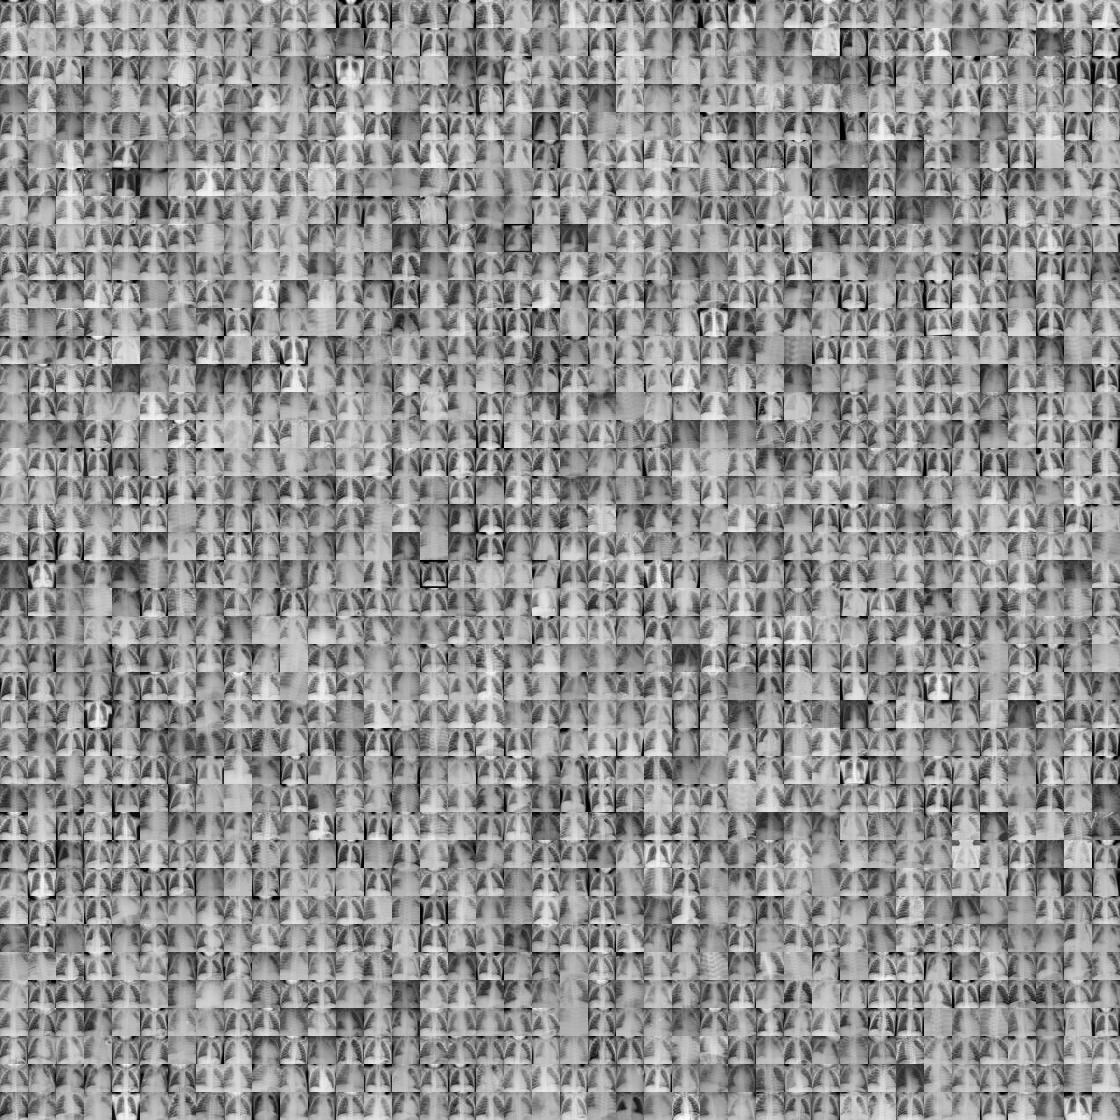

In [8]:
trainX.montage(length=40)

### Set de validacion

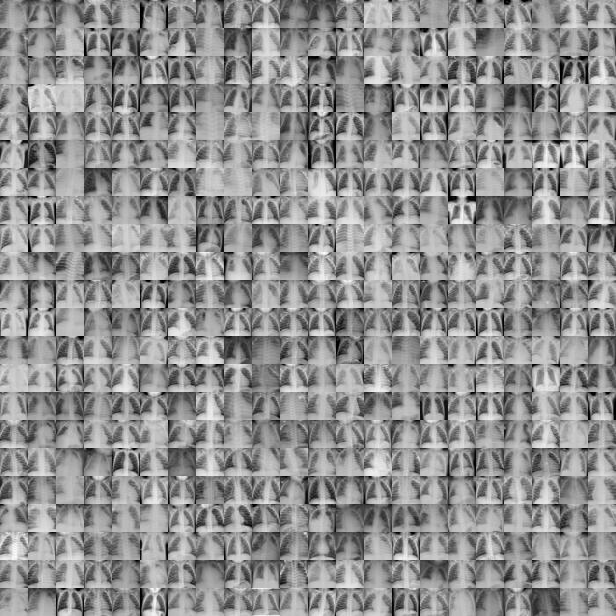

In [9]:
validX.montage(length=22)

### Set de test

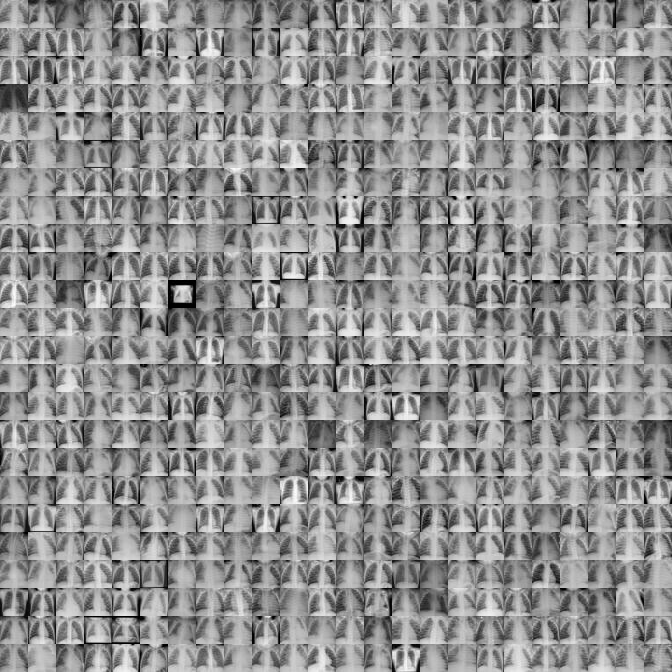

In [10]:
testX.montage(length=24)

# Preprocesamiento de datos

### Normalizamos el valor de la intensidad de la escala de gris en cada pixel

In [11]:
trainX = trainX.imgs / 255.0
validX = validX.imgs / 255.0
testX = testX.imgs / 255.0

In [12]:
(np.max(trainX),np.min(trainX))

(1.0, 0.0)

In [13]:
np.max(validX),np.min(validX)

(1.0, 0.0)

In [14]:
np.max(testX),np.min(testX)

(0.996078431372549, 0.0)

### Ahora se debe convertir los labels a formato OneHotEncoder

In [15]:

trainY = tensorflow.keras.utils.to_categorical(trainY, dtype='uint8');
validY = tensorflow.keras.utils.to_categorical(validY, dtype='uint8');
testY = tensorflow.keras.utils.to_categorical(testY, dtype='uint8');

trainY, validY, testY

(array([[0, 1],
        [0, 1],
        [0, 1],
        ...,
        [0, 1],
        [1, 0],
        [0, 1]], dtype=uint8),
 array([[0, 1],
        [0, 1],
        [0, 1],
        ...,
        [0, 1],
        [1, 0],
        [0, 1]], dtype=uint8),
 array([[0, 1],
        [1, 0],
        [0, 1],
        ...,
        [1, 0],
        [1, 0],
        [1, 0]], dtype=uint8))

# Antes de pasar al Transfer Learning y utilizar modelos pre-entrenados, se debe tomar en cuenta lo siguiente


Como se vio anteriormente las imagenes importadas son de dimensiones 28x28x1, lo que quiere decir que tienen 28 pixeles de ancho y alto y 1 solo canal el cual es en escala de grises. Esto presenta el siguiente inconveniente: Los modelos pre-entrenados tienen unos requisitos para utilizarse. las minimas dimensiones de las imagenes deben ser de 32x32 y se deben trabajar los canales RGB.

Tampoco se puede modificar directamente la capa de entrada del modelo pre-entrenado para que se adapte a nuestros datos de entrada, esto debido a que cuando se reemplaza la capa de entrada del CNN pre-entrenado se esta eliminando la informacion valiosa que las capas subsiguientes esperan recibir. Esto es causa de que las capas posteriores se entrenaron para trabajar con caracteristicas especificas extraidas por las capas anteriores. 

En resumen, reemplazar la capa de entrada del CNN pre-entrenado implica perder el conocimiento aprendido en las capas subsiguientes, ya que necesitarian ser reentrenadas para adaptarse a la nueva entrada. Esto es porque las capas subsiguientes esperan caracteristicas especificas que ya no se proporcionan al cambiar la capa de entrada.

### Como alternativa se redimensionaran las imagenes a 32x32x3, lo que quiere decir que tendran una nueva dimension de 32 pixeles de ancho y alto. Además de tener 3 canales, uno para rojos, uno para verdes y otro para azules(RGB).

### Hay que tomar en cuenta que los valores de los canales color serán identicos, ya que solo se está duplicando la informacion de escala de grises en los color RGB

# Redimensionar imagenes

### Redimensionar con padding

In [16]:
# Tamaño de destino después del padding
desired_size = (32, 32)

# Crear una matriz para almacenar las imágenes con padding
padded_images = np.zeros((trainX.shape[0], desired_size[0], desired_size[1]))

# Iterar sobre las imágenes y agregar padding a cada una
for i in range(trainX.shape[0]):
    image = trainX[i]
    padding_height = desired_size[0] - image.shape[0]
    padding_width = desired_size[1] - image.shape[1]
    top_padding = padding_height // 2
    bottom_padding = padding_height - top_padding
    left_padding = padding_width // 2
    right_padding = padding_width - left_padding

    padded_image = np.pad(image, ((top_padding, bottom_padding), (left_padding, right_padding)), mode='constant')
    padded_images[i] = padded_image

trainX_padded = padded_images
trainX_padded.shape


# Crear una matriz para almacenar las imágenes con padding
padded_images = np.zeros((validX.shape[0], desired_size[0], desired_size[1]))

# Iterar sobre las imágenes y agregar padding a cada una
for i in range(validX.shape[0]):
    image = validX[i]
    padding_height = desired_size[0] - image.shape[0]
    padding_width = desired_size[1] - image.shape[1]
    top_padding = padding_height // 2
    bottom_padding = padding_height - top_padding
    left_padding = padding_width // 2
    right_padding = padding_width - left_padding

    padded_image = np.pad(image, ((top_padding, bottom_padding), (left_padding, right_padding)), mode='constant')

validX_padded = padded_images


# Crear una matriz para almacenar las imágenes con padding
padded_images = np.zeros((testX.shape[0], desired_size[0], desired_size[1]))

# Iterar sobre las imágenes y agregar padding a cada una
for i in range(testX.shape[0]):
    image = testX[i]
    padding_height = desired_size[0] - image.shape[0]
    padding_width = desired_size[1] - image.shape[1]
    top_padding = padding_height // 2
    bottom_padding = padding_height - top_padding
    left_padding = padding_width // 2
    right_padding = padding_width - left_padding

    padded_image = np.pad(image, ((top_padding, bottom_padding), (left_padding, right_padding)), mode='constant')
    padded_images[i] = padded_image

testX_padded = padded_images


print(f"El shape del set de entrenamiento, validacion y test con padding quedaron de la siguiente manera:\n \nSet de entrenamiento: {trainX_padded.shape}, Set de validacion: {validX_padded.shape} y  Set de test: {testX_padded.shape}");

El shape del set de entrenamiento, validacion y test con padding quedaron de la siguiente manera:
 
Set de entrenamiento: (4708, 32, 32), Set de validacion: (524, 32, 32) y  Set de test: (624, 32, 32)


### Redimensionar sin padding

In [17]:
#Redimensionar a 32x32 sin padding
trainX_no_padding = []
validX_no_padding = []
testX_no_padding = []

for i in trainX:
    a = cv2.resize(i, (32,32))
    trainX_no_padding.append(a)

trainX_no_padding = np.array(trainX_no_padding)



for i in validX:
    a = cv2.resize(i, (32,32))
    validX_no_padding.append(a)

validX_no_padding = np.array(validX_no_padding)



for i in testX:
    a = cv2.resize(i, (32,32))
    testX_no_padding.append(a)

testX_no_padding = np.array(testX_no_padding)

print(f"El shape del set de entrenamiento, validacion y test sin padding quedaron de la siguiente manera:\n \nSet de entrenamiento: {trainX_no_padding.shape}, Set de validacion: {validX_no_padding.shape} y  Set de test: {testX_no_padding.shape}");

El shape del set de entrenamiento, validacion y test sin padding quedaron de la siguiente manera:
 
Set de entrenamiento: (4708, 32, 32), Set de validacion: (524, 32, 32) y  Set de test: (624, 32, 32)


# Visualizar imagenes redimensionadas

### Imagenes redimensionadas con padding

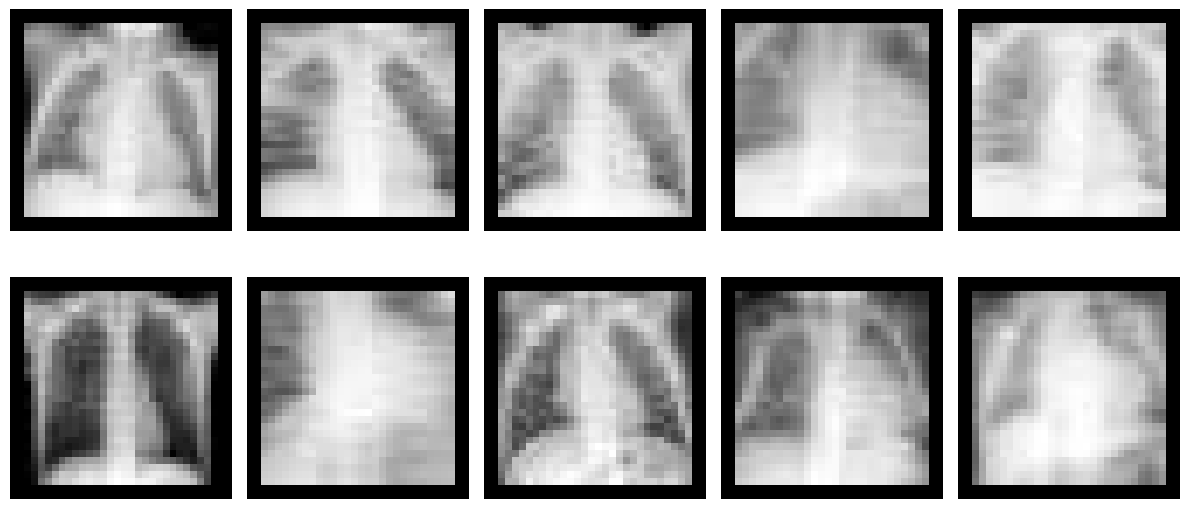

In [18]:
# Obtener las primeras 10 imágenes de entrenamiento
images = trainX_padded[:10]
labels = trainY[:10]

# Crear una figura con 2 filas y 5 columnas para mostrar las imágenes


fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Iterar sobre las imágenes y mostrarlas en los subplots
for i, ax in enumerate(axes.flatten()):
    image = images[i]
    label = labels[i]
    ax.imshow(image, cmap='gray')
    #ax.set_title(f"Label: {label}")
    ax.axis('off')

# Ajustar el espacio entre las imágenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Imagenes redimensionadas sin padding

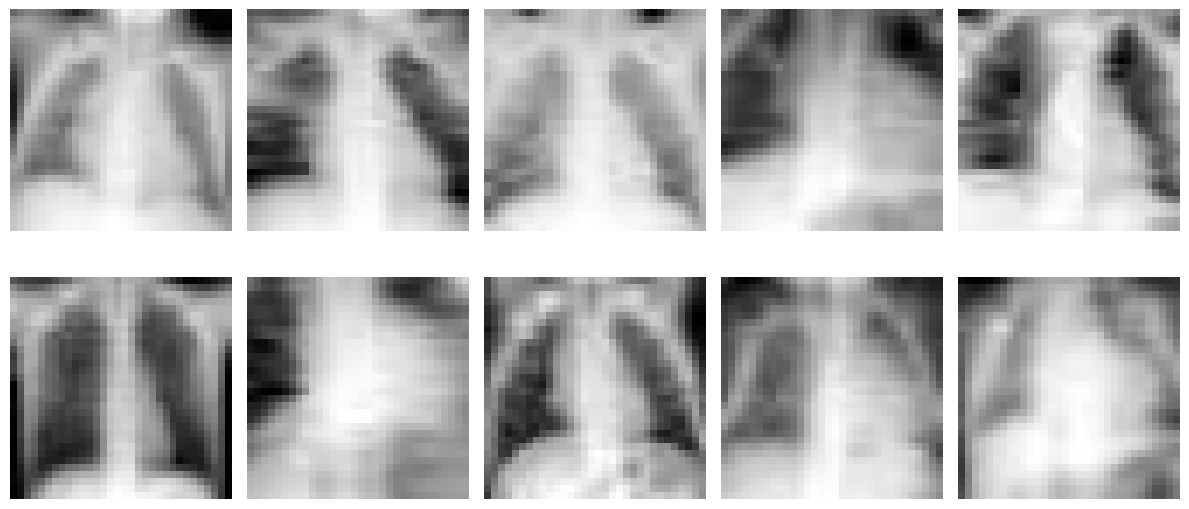

In [19]:
# Obtener las primeras 10 imágenes de entrenamiento
images = trainX_no_padding[:10]
labels = trainY[:10]

# Crear una figura con 2 filas y 5 columnas para mostrar las imágenes
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Iterar sobre las imágenes y mostrarlas en los subplots
for i, ax in enumerate(axes.flatten()):
    image = images[i]
    label = labels[i]
    ax.imshow(image, cmap='gray')
    #ax.set_title(f"Label: {label}")
    ax.axis('off')

# Ajustar el espacio entre las imágenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Transformar imagenes de escala de grises a RGB

In [20]:
# Convertir imágenes en escala de grises a formato RGB
#Padding

trainX_padded = np.repeat(trainX_padded[..., np.newaxis], 3, axis=-1)

validX_padded = np.repeat(validX_padded[..., np.newaxis], 3, axis=-1)

testX_padded = np.repeat(testX_padded[..., np.newaxis], 3, axis=-1)


#No padded

trainX_no_padding = np.repeat(trainX_no_padding[..., np.newaxis], 3, axis=-1)

validX_no_padding = np.repeat(validX_no_padding[..., np.newaxis], 3, axis=-1)

testX_no_padding = np.repeat(testX_no_padding[..., np.newaxis], 3, axis=-1)

In [21]:
print(f"El shape del set de entrenamiento, validacion y test con padding quedaron de la siguiente manera:\n \nSet de entrenamiento: {trainX_padded.shape}, Set de validacion: {validX_padded.shape} y  Set de test: {testX_padded.shape}");

print(f"\nEl shape del set de entrenamiento, validacion y test sin padding quedaron de la siguiente manera:\n \nSet de entrenamiento: {trainX_no_padding.shape}, Set de validacion: {validX_no_padding.shape} y  Set de test: {testX_no_padding.shape}");

El shape del set de entrenamiento, validacion y test con padding quedaron de la siguiente manera:
 
Set de entrenamiento: (4708, 32, 32, 3), Set de validacion: (524, 32, 32, 3) y  Set de test: (624, 32, 32, 3)

El shape del set de entrenamiento, validacion y test sin padding quedaron de la siguiente manera:
 
Set de entrenamiento: (4708, 32, 32, 3), Set de validacion: (524, 32, 32, 3) y  Set de test: (624, 32, 32, 3)


In [22]:
(trainY[0], validY[3]) # (Neumonia, Normal).  [Normal, Neumonia]

(array([0, 1], dtype=uint8), array([1, 0], dtype=uint8))

# Transfer Learning

### Se utilizara la arquitectura de ResNet50 como base para los modelos

In [23]:
base_model = tensorflow.keras.applications.ResNet50(include_top=False,
                                                    weights="imagenet",
                                                    input_shape=(32, 32, 3),
                                                    pooling='max',
                                                    classes=2)

In [24]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

### No se modificaran los pesos y bias del modelo base, por lo que se debera bloquear los parametros entrenables

In [25]:
for layer in base_model.layers:
    layer.trainable = False

tensorflow.keras.layers.Flatten = tensorflow.keras.layers.Flatten();
denselayer1 = tensorflow.keras.layers.Dense(100, activation='relu');
denselayer2 = tensorflow.keras.layers.Dense(200, activation='relu');
output_layer = tensorflow.keras.layers.Dense(2, activation='Softmax');

modelo_sin_padding = tensorflow.keras.models.Sequential([
    base_model,
    tensorflow.keras.layers.Flatten,
    denselayer1,
    denselayer2,
    output_layer
])
modelo_padding = tensorflow.keras.models.Sequential([
    base_model,
    tensorflow.keras.layers.Flatten,
    denselayer1,
    denselayer2,
    output_layer
])


### Compilamos ambos modelos

In [36]:
optimizador = tensorflow.keras.optimizers.Adam(learning_rate=0.01)

In [37]:
modelo_sin_padding.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=["Accuracy"])
modelo_padding.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=["Accuracy"])

### Entrenamos los modelos

In [38]:
tb = TensorBoard(log_dir="./logs/modelo_sin_padding")

In [39]:
trainX_no_padding.shape, validX_no_padding.shape

((4708, 32, 32, 3), (524, 32, 32, 3))

In [40]:
trainY.shape, validY.shape

((4708, 2), (524, 2))

In [41]:
modelo_sin_padding.fit(trainX_no_padding,  trainY, epochs=100, validation_data=(validX_no_padding, validY), callbacks=[tb])

Epoch 1/100
148/148 [==============================] - 21s 117ms/step - loss: 3.9548 - Accuracy: 0.7421 - val_loss: 3.9514 - val_Accuracy: 0.7424
Epoch 2/100
148/148 [==============================] - 17s 118ms/step - loss: 3.9548 - Accuracy: 0.7421 - val_loss: 3.9514 - val_Accuracy: 0.7424
Epoch 3/100
136/148 [==========================>...] - ETA: 1s - loss: 3.9647 - Accuracy: 0.7415

KeyboardInterrupt: 

In [32]:
!tensorboard --logdir=./logs

2023-05-26 19:14:35.797309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.3 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [33]:
tb = TensorBoard(log_dir="./logs/modelo_con_padding")

In [34]:
modelo_padding.fit(trainX_padded, trainY, epochs=100, validation_data=(validX_padded, validY), callbacks=[tb])

Epoch 1/100
148/148 [==============================] - 23s 130ms/step - loss: 3.9548 - Accuracy: 0.7421 - val_loss: 3.9514 - val_Accuracy: 0.7424
Epoch 2/100
148/148 [==============================] - 17s 112ms/step - loss: 3.9548 - Accuracy: 0.7421 - val_loss: 3.9514 - val_Accuracy: 0.7424
Epoch 3/100
148/148 [==============================] - 16s 107ms/step - loss: 3.9548 - Accuracy: 0.7421 - val_loss: 3.9514 - val_Accuracy: 0.7424
Epoch 4/100
148/148 [==============================] - 17s 112ms/step - loss: 3.9548 - Accuracy: 0.7421 - val_loss: 3.9514 - val_Accuracy: 0.7424
Epoch 5/100
148/148 [==============================] - 16s 108ms/step - loss: 3.9548 - Accuracy: 0.7421 - val_loss: 3.9514 - val_Accuracy: 0.7424
Epoch 6/100
148/148 [==============================] - 15s 104ms/step - loss: 3.9548 - Accuracy: 0.7421 - val_loss: 3.9514 - val_Accuracy: 0.7424
Epoch 7/100
148/148 [==============================] - 18s 120ms/step - loss: 3.9548 - Accuracy: 0.7421 - val_loss: 3.9514 -

KeyboardInterrupt: 